# **Tugas 4 - Graph**

**Nama : Achmad Baharuddin Akbar**

**NIM  : 210411100001**

In [296]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [297]:
import pandas as pd
import numpy as np
import re
import nltk
!pip install Sastrawi
nltk.download('punkt')

from nltk.corpus import stopwords
#stemming
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

import nltk

from nltk.tokenize import sent_tokenize

import networkx as nx
import matplotlib.pyplot as plt

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [298]:
# Baca file CSV
df = pd.read_csv("/content/drive/MyDrive/PPW-A/report/tugas-ppw/data_berita_detik.csv")
df.head()

,judul,tanggal,isi,kategori
0,Gejala Sifilis pada Wanita Berdasarkan Tahapan...,"Rabu, 16 Okt 2024 21:00 WIB",Jakarta - Sifilis atau penyakit raja singa ter...,Kesehatan
1,Puncak Nafsu Pria Ada di Umur Berapa? Studi Bi...,"Rabu, 16 Okt 2024 20:02 WIB",Jakarta - Sebagian orang pasti sudah mengenal ...,Kesehatan
2,"Gejala Kanker Mulut yang Kerap Tak Disadari, T...","Rabu, 16 Okt 2024 18:02 WIB",Jakarta - Setiap orang mungkin pernah mengalam...,Kesehatan
3,Kapan Waktu yang Tepat untuk Minum Air Rebusan...,"Rabu, 16 Okt 2024 17:31 WIB",Jakarta - Air rebusan serai dikenal sebagai sa...,Kesehatan
4,Viral Hanni NewJeans Bicara soal Bullying di T...,"Rabu, 16 Okt 2024 16:34 WIB","Jakarta - Viral momen member NewJeans, Hanni, ...",Kesehatan


In [299]:
# mengambil satu sample berita
sample_berita = df['isi'].iloc[7] # 8 kalimat
# sample_berita = df['isi'].iloc[4]
print(sample_berita)

Jakarta - Manfaat dari terapi pijat selain relaksasi adalah menghilangkan pegal, meredakan stres, dan meningkatkan kualitas tidur. Namun, ada beberapa kendala yang sering dijumpai ketika kita hendak menuju tempat pijat, seperti merasa malas saat ingin menempuh jarak yang jauh, harus masuk mall, dan ada rasa ingin cepat sampai ke rumah. Ditambah lagi saat jam pulang kerja atau weekend biasanya antrean lebih panjang dan membuat kita mengurungkan niat untuk relaksasi. dok: XLIFE Tapi saat ini kamu tidak perlu khawatir, hanya dengan membuka aplikasi XLIFE kamu bisa mendatangkan jasa terapis profesional berpengalaman ke rumah kamu dengan cepat dan tanpa antre! dok: XLIFE Dengan pilihan mitra yang telah tersertifikasi dan memiliki pengalaman bekerja di bidangnya lebih dari lima tahun. XLIFE hadir untuk mempermudah masyarakat mendapatkan layanan terapi pijat yang nyaman, aman, dan tanpa ribet. XLIFE kini sudah hadir di 9 kota besar Indonesia, yaitu di Jabodetabek, Bandung, Yogyakarta, Semaran

In [300]:
# Membuat list untuk menyimpan hasil
result_list = []

# Pisahkan kalimat berdasarkan titik
sentences = sample_berita.split('.')  # Pisahkan kalimat berdasarkan titik
sentences = [s.strip() for s in sentences if s.strip()]  # Hilangkan spasi berlebih dan kosong

# Looping untuk menambahkan setiap kalimat ke result_list
for i, sentence in enumerate(sentences, 1):
    result_list.append({'kalimat ke n': f"Kalimat ke {i}", 'kalimat': sentence})

# Membuat DataFrame dari hasil pemisahan
result_df = pd.DataFrame(result_list)

# Tampilkan DataFrame
result_df

,kalimat ke n,kalimat
0,Kalimat ke 1,Jakarta - Manfaat dari terapi pijat selain rel...
1,Kalimat ke 2,"Namun, ada beberapa kendala yang sering dijump..."
2,Kalimat ke 3,Ditambah lagi saat jam pulang kerja atau weeke...
3,Kalimat ke 4,dok: XLIFE Tapi saat ini kamu tidak perlu khaw...
4,Kalimat ke 5,XLIFE hadir untuk mempermudah masyarakat menda...
5,Kalimat ke 6,XLIFE kini sudah hadir di 9 kota besar Indones...
6,Kalimat ke 7,"Dengan berbagai layanan pijat, antara lain pij..."
7,Kalimat ke 8,"Selain pijat, XLIFE juga melayani cleaning, pe..."


In [301]:
# Download stopwords untuk bahasa Indonesia
nltk.download('stopwords')
stop_words = stopwords.words('indonesian')

# Fungsi preprocessing yang disesuaikan
def remove_url(data_berita):
    url = re.compile(r'https?://\S+|www\.S+')
    return url.sub(r'', data_berita)

def remove_html(data_berita):
    html = re.compile(r'<.#?>')
    return html.sub(r'', data_berita)

def remove_emoji(data_berita):
    emoji_pattern = re.compile("["
        u"\U0001F600-\U0001F64F"  # emoticon
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
        "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', data_berita)

def remove_numbers(data_berita):
    data_berita = re.sub(r'\d+', '', data_berita)
    return data_berita

def remove_symbols(data_berita):
    data_berita = re.sub(r'[^a-zA-Z0-9\s]', '', data_berita)
    return data_berita

def case_folding(text):
    if isinstance(text, str):
        return text.lower()
    return text

def tokenize(text):
    return text.split()

def remove_stopwords(text):
    return [word for word in text if word not in stop_words]

# Inisialisasi stemmer
factory = StemmerFactory()
stemmer = factory.create_stemmer()

def stemming(text):
    return [stemmer.stem(word) for word in text]

# Looping setiap kalimat di dataframe 'result_df'
result_df['clean'] = result_df['kalimat'].apply(remove_url)
result_df['clean'] = result_df['clean'].apply(remove_html)
result_df['clean'] = result_df['clean'].apply(remove_emoji)
result_df['clean'] = result_df['clean'].apply(remove_symbols)
result_df['clean'] = result_df['clean'].apply(remove_numbers)
result_df['clean'] = result_df['clean'].apply(case_folding)
result_df['tokenize'] = result_df['clean'].apply(tokenize)
result_df['stopword removal'] = result_df['tokenize'].apply(remove_stopwords)
result_df['stemming'] = result_df['stopword removal'].apply(stemming)

# Gabungkan kata setelah stemming
result_df['final'] = result_df['stemming'].apply(lambda x: ' '.join(x))

# Tampilkan hasil dataframe
result_df[['kalimat ke n', 'final']]

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


,kalimat ke n,final
0,Kalimat ke 1,jakarta manfaat terapi pijat relaksasi hilang ...
1,Kalimat ke 2,kendala jumpa pijat malas tempuh jarak masuk m...
2,Kalimat ke 3,tambah jam pulang kerja weekend antre urung ni...
3,Kalimat ke 4,dok xlife khawatir buka aplikasi xlife jasa te...
4,Kalimat ke 5,xlife hadir mudah masyarakat layan terapi pija...
5,Kalimat ke 6,xlife hadir kota indonesia jabodetabek bandung...
6,Kalimat ke 7,layan pijat pijat sehat prenatal massage pijat...
7,Kalimat ke 8,pijat xlife layan cleaning baik elektronik cuc...


In [302]:
# Gabungkan semua kalimat hasil stemming menjadi dokumen untuk tiap kalimat
documents = result_df['final'].tolist()

# Inisialisasi TF-IDF Vectorizer
tfidf_vectorizer = TfidfVectorizer()

# Terapkan TF-IDF ke dokumen (kalimat yang sudah dipreproses)
tfidf_matrix = tfidf_vectorizer.fit_transform(documents)

# Mendapatkan nama-nama fitur (kata-kata)
feature_names = tfidf_vectorizer.get_feature_names_out()

# Mengubah hasil TF-IDF menjadi dataframe
tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), columns=feature_names)

# Tambahkan kolom 'no' dan 'kalimat ke n' untuk identifikasi
tfidf_df.insert(0, 'kalimat ke n', result_df['kalimat ke n'])

# Tampilkan dataframe dengan skor TF-IDF
tfidf_df

,kalimat ke n,alam,aman,antre,aplikasi,app,baik,bal,balita,bandung,...,tempuh,temu,terap,terapi,tidur,tingkat,urung,weekend,xlife,yogyakarta
0,Kalimat ke 1,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.255972,0.305427,0.305427,0.000000,0.000000,0.000000,0.000000
1,Kalimat ke 2,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.338647,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,Kalimat ke 3,0.00000,0.000000,0.289083,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.344935,0.344935,0.000000,0.000000
3,Kalimat ke 4,0.41384,0.000000,0.173415,0.173415,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.173415,0.000000,0.000000,0.000000,0.000000,0.000000,0.393612,0.000000
4,Kalimat ke 5,0.00000,0.361673,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.303110,0.000000,0.000000,0.000000,0.000000,0.229330,0.000000
5,Kalimat ke 6,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.287427,0.000000,0.287427,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.182252,0.287427
6,Kalimat ke 7,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.335555,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
7,Kalimat ke 8,0.00000,0.000000,0.000000,0.167544,0.199914,0.199914,0.000000,0.000000,0.000000,...,0.000000,0.199914,0.167544,0.000000,0.000000,0.000000,0.000000,0.000000,0.253523,0.000000


In [303]:
# Menghitung cosine similarity antar kalimat berdasarkan TF-IDF
cosine_sim = cosine_similarity(tfidf_matrix)

# Membuat dataframe untuk menyimpan hasil cosine similarity
cosine_sim_df = pd.DataFrame(cosine_sim, index=result_df['kalimat ke n'], columns=result_df['kalimat ke n'])

# Tampilkan matriks cosine similarity
cosine_sim_df

kalimat ke n,Kalimat ke 1,Kalimat ke 2,Kalimat ke 3,Kalimat ke 4,Kalimat ke 5,Kalimat ke 6,Kalimat ke 7,Kalimat ke 8
kalimat ke n,,,,,,,,
Kalimat ke 1,1.000000,0.032584,0.073997,0.000000,0.112387,0.000000,0.096858,0.038470
Kalimat ke 2,0.032584,1.000000,0.000000,0.098435,0.038584,0.000000,0.107393,0.042655
Kalimat ke 3,0.073997,0.000000,1.000000,0.050131,0.000000,0.000000,0.000000,0.000000
Kalimat ke 4,0.000000,0.098435,0.050131,1.000000,0.090267,0.071737,0.036314,0.208589
Kalimat ke 5,0.112387,0.038584,0.000000,0.090267,1.000000,0.114811,0.178168,0.141510
Kalimat ke 6,0.000000,0.000000,0.000000,0.071737,0.114811,1.000000,0.000000,0.046205
Kalimat ke 7,0.096858,0.107393,0.000000,0.036314,0.178168,0.000000,1.000000,0.196964
Kalimat ke 8,0.038470,0.042655,0.000000,0.208589,0.141510,0.046205,0.196964,1.000000


In [304]:
from sklearn.metrics import jaccard_score

# Fungsi untuk menghitung Jaccard similarity antar vektor
def calculate_jaccard_similarity(tfidf_matrix):
    # Inisialisasi matriks untuk menyimpan hasil Jaccard similarity
    num_sentences = tfidf_matrix.shape[0]
    jaccard_similarity_matrix = np.zeros((num_sentences, num_sentences))

    # Looping untuk menghitung Jaccard similarity antara setiap pasangan kalimat
    for i in range(num_sentences):
        for j in range(num_sentences):
            # Hitung Jaccard similarity berdasarkan vektor biner
            jaccard_similarity_matrix[i, j] = jaccard_score(tfidf_matrix[i].toarray()[0] > 0,
                                                            tfidf_matrix[j].toarray()[0] > 0)
    return jaccard_similarity_matrix

# Hitung Jaccard similarity matriks dari TF-IDF
jaccard_similarity = calculate_jaccard_similarity(tfidf_matrix)

# Membuat DataFrame dari matriks Jaccard similarity
jaccard_df = pd.DataFrame(jaccard_similarity,
                          index=result_df['kalimat ke n'],
                          columns=result_df['kalimat ke n'])

# Tampilkan DataFrame Jaccard similarity
jaccard_df

kalimat ke n,Kalimat ke 1,Kalimat ke 2,Kalimat ke 3,Kalimat ke 4,Kalimat ke 5,Kalimat ke 6,Kalimat ke 7,Kalimat ke 8
kalimat ke n,,,,,,,,
Kalimat ke 1,1.000000,0.047619,0.05,0.000000,0.100000,0.000000,0.052632,0.029412
Kalimat ke 2,0.047619,1.000000,0.00,0.080000,0.052632,0.000000,0.058824,0.031250
Kalimat ke 3,0.050000,0.000000,1.00,0.040000,0.000000,0.000000,0.000000,0.000000
Kalimat ke 4,0.000000,0.080000,0.04,1.000000,0.038462,0.034483,0.041667,0.142857
Kalimat ke 5,0.100000,0.052632,0.00,0.038462,1.000000,0.095238,0.125000,0.100000
Kalimat ke 6,0.000000,0.000000,0.00,0.034483,0.095238,1.000000,0.000000,0.028571
Kalimat ke 7,0.052632,0.058824,0.00,0.041667,0.125000,0.000000,1.000000,0.107143
Kalimat ke 8,0.029412,0.031250,0.00,0.142857,0.100000,0.028571,0.107143,1.000000


In [305]:
# Tetapkan ambang batas (threshold) 0.7
threshold = 0.05

# Buat matriks adjacency: jika cosine similarity >= 0.6, maka 1; jika tidak, maka 0
adjacency_matrix = np.where(cosine_sim >= threshold, 1, 0)

# Buat dataframe untuk menampilkan matriks adjacency
adjacency_df = pd.DataFrame(adjacency_matrix, index=result_df['kalimat ke n'], columns=result_df['kalimat ke n'])

# Tampilkan matriks adjacency
adjacency_df

kalimat ke n,Kalimat ke 1,Kalimat ke 2,Kalimat ke 3,Kalimat ke 4,Kalimat ke 5,Kalimat ke 6,Kalimat ke 7,Kalimat ke 8
kalimat ke n,,,,,,,,
Kalimat ke 1,1,0,1,0,1,0,1,0
Kalimat ke 2,0,1,0,1,0,0,1,0
Kalimat ke 3,1,0,1,1,0,0,0,0
Kalimat ke 4,0,1,1,1,1,1,0,1
Kalimat ke 5,1,0,0,1,1,1,1,1
Kalimat ke 6,0,0,0,1,1,1,0,0
Kalimat ke 7,1,1,0,0,1,0,1,1
Kalimat ke 8,0,0,0,1,1,0,1,1


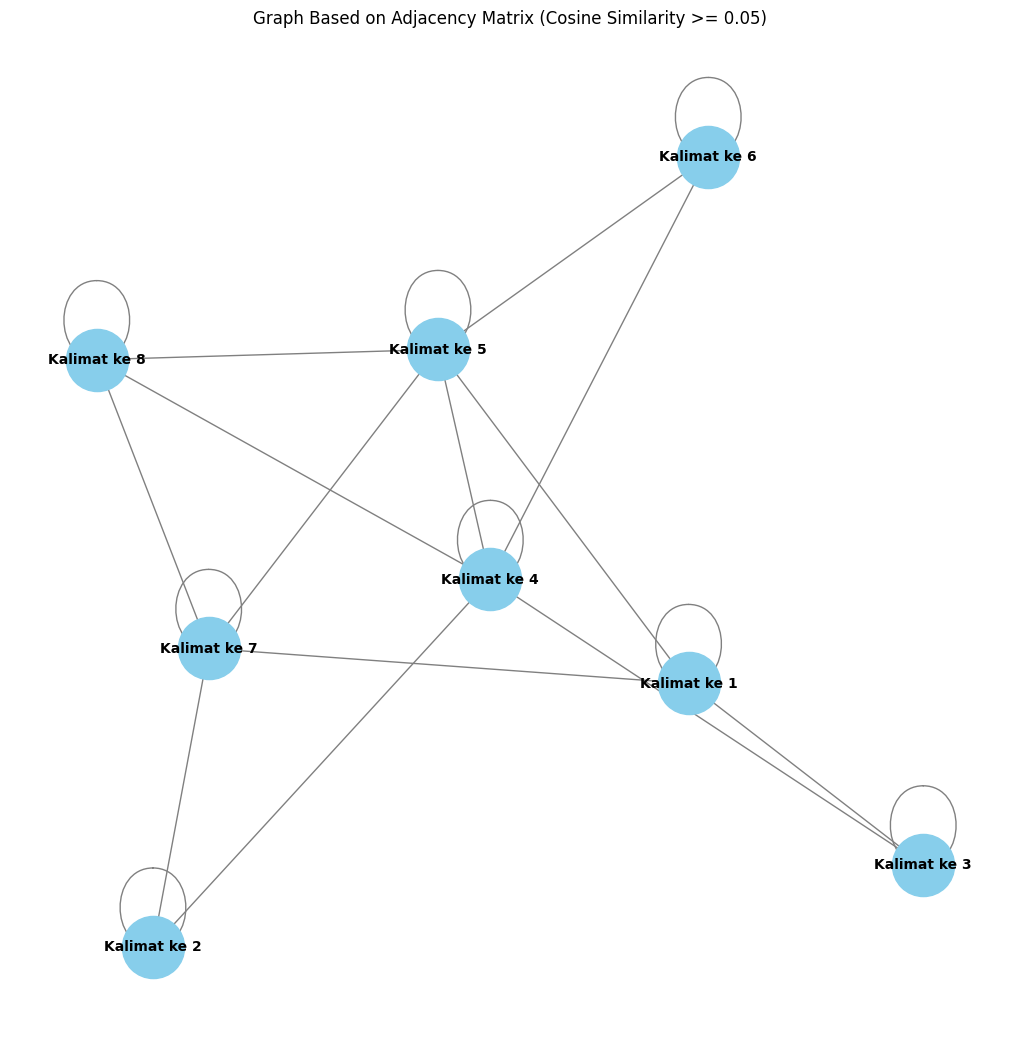

In [306]:
# Buat graf dari matriks adjacency
G = nx.from_numpy_array(adjacency_matrix)

# Atur label node agar sesuai dengan 'kalimat ke n'
mapping = {i: f"Kalimat ke {i+1}" for i in range(len(result_df))}
G = nx.relabel_nodes(G, mapping)

# Menggambar graf
plt.figure(figsize=(10, 10))
pos = nx.spring_layout(G)
nx.draw(G, pos, with_labels=True, node_color='skyblue', node_size=2000, font_size=10, font_color='black', edge_color='gray', linewidths=1, font_weight='bold')

# Tampilkan graf
plt.title("Graph Based on Adjacency Matrix (Cosine Similarity >= 0.05)")
plt.show()

In [307]:
# Menghitung betweenness centrality
betweenness_centrality = nx.betweenness_centrality(G)

# Menghitung degree centrality
degree_centrality = nx.degree_centrality(G)

# Menghitung closeness centrality
closeness_centrality = nx.closeness_centrality(G)

# Buat dataframe untuk menampilkan hasil centrality
centrality_df = pd.DataFrame({
    'Kalimat': list(betweenness_centrality.keys()),
    'Betweenness Centrality': list(betweenness_centrality.values()),
    'Degree Centrality': list(degree_centrality.values()),
    'Closeness Centrality': list(closeness_centrality.values())
})

# Tampilkan dataframe centrality
centrality_df

,Kalimat,Betweenness Centrality,Degree Centrality,Closeness Centrality
0,Kalimat ke 1,0.071429,0.714286,0.636364
1,Kalimat ke 2,0.015873,0.571429,0.583333
2,Kalimat ke 3,0.023810,0.571429,0.583333
3,Kalimat ke 4,0.285714,1.000000,0.777778
4,Kalimat ke 5,0.182540,1.000000,0.777778
5,Kalimat ke 6,0.000000,0.571429,0.583333
6,Kalimat ke 7,0.119048,0.857143,0.700000
7,Kalimat ke 8,0.015873,0.714286,0.636364


In [308]:
top_5_sentences = centrality_df.sort_values(by='Betweenness Centrality', ascending=False).head(5)
top_5_sentences

,Kalimat,Betweenness Centrality,Degree Centrality,Closeness Centrality
3,Kalimat ke 4,0.285714,1.000000,0.777778
4,Kalimat ke 5,0.182540,1.000000,0.777778
6,Kalimat ke 7,0.119048,0.857143,0.700000
0,Kalimat ke 1,0.071429,0.714286,0.636364
2,Kalimat ke 3,0.023810,0.571429,0.583333
